Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         4

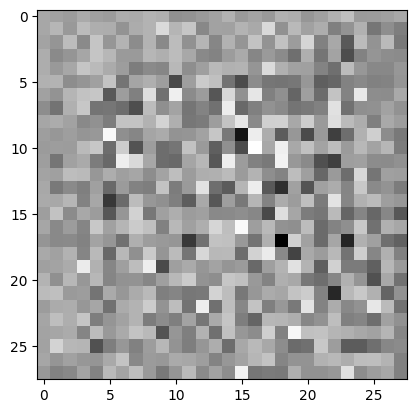

In [1]:
import tensorflow as tf
from tensorflow import optimizers
from tensorflow import experimental
import keras
import time
import os
import imageio
from PIL import Image
from IPython import display
from keras import layers
from tensorflow.python.client import device_lib
from keras import utils
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import numpy as np
import glob
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(32)
def make_discrimination():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1000,activation=tf.keras.activations.relu))
    model.add(layers.Dense(500,activation=tf.keras.activations.relu))
    model.add(layers.Dense(100,activation=tf.keras.activations.relu))
    model.add(layers.Dense(1))
    return model
def make_generator():
    m=tf.keras.Sequential(
        layers=[layers.Dense(input_shape=(100,),units=7*7*256),
                layers.BatchNormalization(),
                layers.LeakyReLU(),
                layers.Reshape((7,7,256)),
                layers.Conv2DTranspose(128,(5,5),padding="same"),
                layers.BatchNormalization(),
                layers.LeakyReLU(),
                layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same"),
                layers.BatchNormalization(),
                layers.LeakyReLU(),
                layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",activation="tanh")
            ]
    )
    return m
dis=make_discrimination()
gen=make_generator()
dis.summary()
gen.summary()
n=tf.random.normal([1,100])
plt.imshow(gen(n,training=False)[0,:,:,0],cmap="gray")


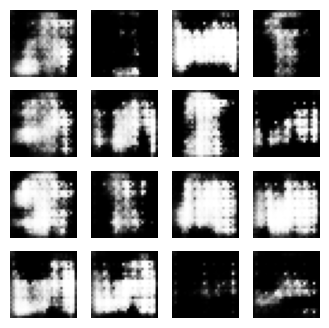

Time for epoch 1 is 26.804993391036987 sec


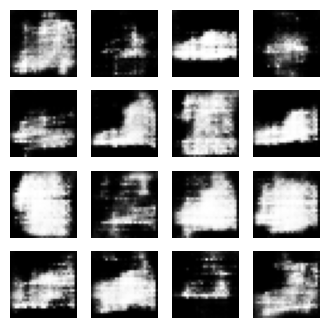

Time for epoch 2 is 23.305376052856445 sec


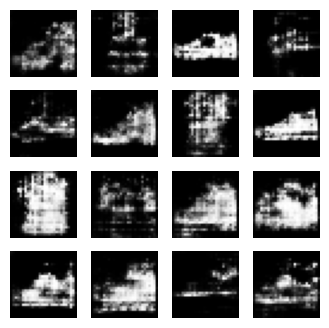

Time for epoch 3 is 23.871353149414062 sec


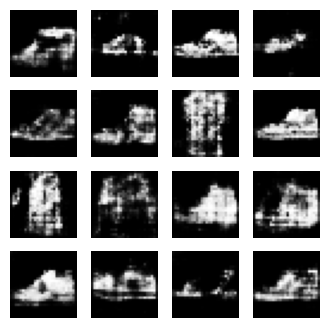

Time for epoch 4 is 25.64144492149353 sec


In [2]:
cross=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def gen_loss(x):
    return cross(tf.ones_like(x),x)
def dis_loss(x,y):
    return cross(tf.ones_like(x),x)+cross(tf.zeros_like(y),y)
gen_opti=tf.keras.optimizers.Adam(1e-4)
dis_opti=tf.keras.optimizers.Adam(1e-4)
batch_size=32
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opti,
                                 discriminator_optimizer=dis_opti,
                                 generator=gen,
                                 discriminator=dis)
seed = tf.random.normal([16, 100])

@tf.function
def train_step(x):
    noise=tf.random.normal([batch_size,100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        gx=gen(noise,training=True)
        ry,fy=dis(x,training=True),dis(gx,training=True)
        gl,dl=gen_loss(fy),dis_loss(ry,fy)
    gog,god=gen_tape.gradient(gl,gen.trainable_variables),dis_tape.gradient(dl,dis.trainable_variables)
    gen_opti.apply_gradients(zip(gog,gen.trainable_variables))
    dis_opti.apply_gradients(zip(god,dis.trainable_variables))
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)


    generate_and_save_images(gen,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(gen,
                           epochs,
                           seed)
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5,cmap="gray")
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
train(train_images,epochs=5)

In [ ]:
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
anim_file = 'dcgan3.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


C:\Users\divya\AppData\Local\Temp\ipykernel_8568\3802578107.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\divya\AppData\Local\Temp\ipykernel_8568\3802578107.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
